In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Loss Function
from src.model.loss.tensorflow_no_finding_binary_crossentropy import NoFindingBinaryCrossentropy

In [2]:
def generate_synthetic_data(num_samples=1000, num_classes=15, no_finding_idx=10):
    other_preds_range = np.linspace(0, 1, num_samples)
    
    scenarios = [
        ("True No Finding, Low Other", 1.0, 0.9, other_preds_range),
        ("False No Finding, Low Other", 0.0, 0.1, other_preds_range),
    ]
    
    results = []
    for name, true_no_finding, pred_no_finding, other_preds in scenarios:
        y_true = np.zeros((num_samples, num_classes))
        y_true[:, no_finding_idx] = true_no_finding
        
        if "False No Finding" in name:
            true_positive_classes = [1, 3, 8]
            for cls in true_positive_classes:
                y_true[:, cls] = 1.0
        
        y_pred = np.zeros((num_samples, num_classes))
        y_pred[:, no_finding_idx] = pred_no_finding
        
        for i, val in enumerate(other_preds):
            if "True No Finding" in name:
                other_classes = [j for j in range(num_classes) if j != no_finding_idx]
                avg_val = val / (num_classes - 1)
                for j in other_classes:
                    y_pred[i, j] = avg_val
            else:
                classes_to_predict = [1, 3, 8]
                for cls in classes_to_predict:
                    y_pred[i, cls] = val
        
        results.append((name, y_true, y_pred))
    
    return results
    
synthetic_data = generate_synthetic_data()
print(synthetic_data)

[('True No Finding, Low Other', array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.15000715e-05, 7.15000715e-05, 7.15000715e-05, ...,
        7.15000715e-05, 7.15000715e-05, 7.15000715e-05],
       [1.43000143e-04, 1.43000143e-04, 1.43000143e-04, ...,
        1.43000143e-04, 1.43000143e-04, 1.43000143e-04],
       ...,
       [7.12855713e-02, 7.12855713e-02, 7.12855713e-02, ...,
        7.12855713e-02, 7.12855713e-02, 7.12855713e-02],
       [7.13570714e-02, 7.13570714e-02, 7.13570714e-02, ...,
        7.13570714e-02, 7.13570714e-02, 7.13570714e-02],
       [7.14285714e-02, 7.14285714e-02, 7.14285714e-02, ...,
        7.14285714e-02, 7.14285714e-02, 7.14285714e-02]])), ('F

Scenarios: : 0it [00:00, ?it/s]
2025-05-28 21:41:14.223689: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro                            | 0/6 [00:00<?, ?it/s]
2025-05-28 21:41:14.223737: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-05-28 21:41:14.223740: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
I0000 00:00:1748464874.223794  872636 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1748464874.223841  872636 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)

Configs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.48s/it]
Scenarios: : 1i

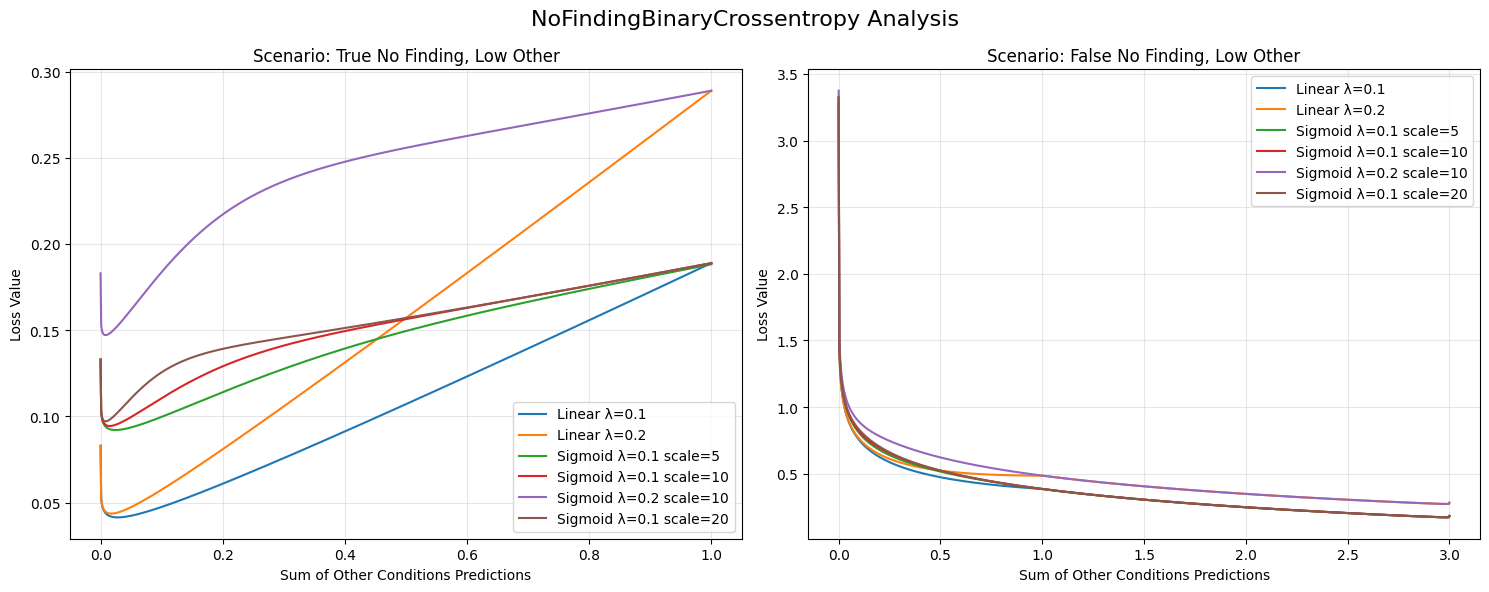

In [3]:
synthetic_data = generate_synthetic_data()

# Test different configurations
configs = [
    {"with_sigmoid": False, "sigmoid_scale": None, "lambda_value": 0.1, "label": "Linear λ=0.1"},
    {"with_sigmoid": False, "sigmoid_scale": None, "lambda_value": 0.2, "label": "Linear λ=0.2"},
    {"with_sigmoid": True, "sigmoid_scale": 5, "lambda_value": 0.1, "label": "Sigmoid λ=0.1 scale=5"},
    {"with_sigmoid": True, "sigmoid_scale": 10, "lambda_value": 0.1, "label": "Sigmoid λ=0.1 scale=10"},
    {"with_sigmoid": True, "sigmoid_scale": 10, "lambda_value": 0.2, "label": "Sigmoid λ=0.2 scale=10"},
    {"with_sigmoid": True, "sigmoid_scale": 20, "lambda_value": 0.1, "label": "Sigmoid λ=0.1 scale=20"},
]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('NoFindingBinaryCrossentropy Analysis', fontsize=16)

for i, (scenario_name, y_true, y_pred) in tqdm(enumerate(synthetic_data), desc="Scenarios: "):
    ax = axes[i]
    other_sum = np.sum(y_pred, axis=1) - y_pred[:, 10]  # Assumes no_finding_idx=10
    
    for config in tqdm(configs, desc="Configs: "):
        loss_fn = NoFindingBinaryCrossentropy(
            no_finding_idx=10,
            with_sigmoid=config["with_sigmoid"],
            lambda_value=config["lambda_value"],
            sigmoid_scale=config["sigmoid_scale"]
        )
        
        losses = []
        for j in range(len(y_true)):
            sample_true = tf.constant(y_true[j:j+1], dtype=tf.float32)
            sample_pred = tf.constant(y_pred[j:j+1], dtype=tf.float32)
            loss = loss_fn(sample_true, sample_pred).numpy()
            losses.append(loss)
        
        ax.plot(other_sum, losses, label=config["label"])
    
    ax.set_xlabel('Sum of Other Conditions Predictions')
    ax.set_ylabel('Loss Value')
    ax.set_title(f'Scenario: {scenario_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()